# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
import shap
import contextlib
import os

c:\Users\rabia\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
# features
features = fires_dt.columns[fires_dt.columns != 'area']
area = fires_dt.columns[fires_dt.columns == 'area']

# features data frame
X = fires_dt[features]

In [4]:
# target data frame
Y= fires_dt[area]

print('Features data frame: ', X.shape)
print('Target data frame: ', Y.shape)
X.columns

Features data frame:  (517, 12)
Target data frame:  (517, 1)


Index(['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
       'temp', 'rh', 'wind', 'rain'],
      dtype='object')

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# preproc1

# Defining column names for different types of features (numerical and categorical)
num_feat = X.select_dtypes(include=['int64', 'float64']).columns
cat_feat = X.select_dtypes(include=['object']).columns

# numerical features
nums1 = Pipeline([ 
    ('std_scaler', StandardScaler(),) # Scale numerical features using StandardScaler
])

# categorical features
cat1 = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

preproc1 = ColumnTransformer([
    ('num_transforms', nums1, num_feat), # Apply num_transforms to numerical features
    ('cat_transforms', cat1, cat_feat) # Apply cat_transforms to categorical features
])

print(num_feat)
print(cat_feat)
preproc1

Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')
Index(['month', 'day'], dtype='object')


ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 Index(['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind',
       'rain'],
      dtype='object')),
                                ('cat_transforms',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['month', 'day'], dtype='object'))])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# Create a pipeline for some of the numeric variables using StandardScaler followed by PowerTransformer

# Pipeline for some selected numeric variables (StandardScaler only)
nums1 = Pipeline([
    ('std_scaler', StandardScaler())  # Step 1: Scale numerical features using StandardScaler
])

# Pipeline for some selected numeric variables (StandardScaler + Yeo-Johnson)
nums2 = Pipeline([
    ('std_scaler', StandardScaler()),  # Step 1: Scale numerical features using StandardScaler
    ('transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=False))  # Step 2: Transform them using Yeo-Johnson
])

# Pipeline for categorical features
cat2 = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# ColumnTransformer: Apply different transformations to selected numeric features and categorical features
preproc2 = ColumnTransformer([
    ('num_transforms_nums1', nums1, ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi']),  # Apply nums1 to a subset of numeric variables
    ('num_transforms_nums2', nums2, ['temp', 'rh', 'wind', 'rain']),  # Apply nums2 to a subset of numeric variables
    ('cat_transforms', cat2, cat_feat)  # Apply cat2 to categorical features
])

preproc2

ColumnTransformer(transformers=[('num_transforms_nums1',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi']),
                                ('num_transforms_nums2',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler()),
                                                 ('transform',
                                                  PowerTransformer(copy=False,
                                                                   standardize=False))]),
                                 ['temp', 'rh', 'wind', 'rain']),
                                ('cat_transforms',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['month', 'day'], dtype='object'))])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline

# Create the regression pipeline with LinearRegression
Pipeline_A = Pipeline([
    ('preprocessing', preproc1),  # Preprocessing 1
    ('regressor', LinearRegression())  # LinearRegression as the baseline regressor
])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_results = cross_validate(Pipeline_A, X_train, Y_train, cv=5,
                            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            return_train_score=True)

# Extract cross-validation results
cv_results_pd = pd.DataFrame(cv_results).assign(experiment = 1)
cv_results_pd.mean()

fit_time                              0.039648
score_time                            0.017676
test_neg_root_mean_squared_error    -41.177356
train_neg_root_mean_squared_error   -43.439787
test_neg_mean_absolute_error        -18.486499
train_neg_mean_absolute_error       -16.823114
experiment                            1.000000
dtype: float64

In [8]:
# Pipeline B = preproc2 + baseline

# Create the regression pipeline with LinearRegression
Pipeline_B = Pipeline([
    ('preprocessing', preproc2),  # Preprocessing 2
    ('regressor', LinearRegression())  # LinearRegression as the baseline regressor
])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_results = cross_validate(Pipeline_B, X_train, Y_train, cv=5,
                            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            return_train_score=True)

# Extract cross-validation results
cv_results_pd = pd.DataFrame(cv_results).assign(experiment = 2)
cv_results_pd.mean()

fit_time                              0.056313
score_time                            0.020446
test_neg_root_mean_squared_error    -40.344659
train_neg_root_mean_squared_error   -43.413381
test_neg_mean_absolute_error        -18.130661
train_neg_mean_absolute_error       -16.772249
experiment                            2.000000
dtype: float64

In [9]:
# Pipeline C = preproc1 + advanced model

# Create the regression pipeline with a more advanced regressor
Pipeline_C = Pipeline([
    ('preprocessing', preproc1),  # Preprocessing steps
    ('regressor', HistGradientBoostingRegressor())  # HistGradientBoostingRegressor as the regressor
])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_train_C = Y_train.values.ravel()

# Perform cross-validation on training data
cv_results = cross_validate(Pipeline_C, X_train, Y_train_C, cv=5,
                            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            return_train_score=True)

# Extract cross-validation results
cv_results_pd = pd.DataFrame(cv_results).assign(experiment = 3)
cv_results_pd.mean()

fit_time                              0.927485
score_time                            0.017921
test_neg_root_mean_squared_error    -43.302351
train_neg_root_mean_squared_error   -31.337605
test_neg_mean_absolute_error        -18.828369
train_neg_mean_absolute_error       -10.066525
experiment                            3.000000
dtype: float64

In [25]:
# Pipeline D = preproc2 + advanced model

# Create the regression pipeline with a more advanced regressor
Pipeline_D = Pipeline([
    ('preprocessing', preproc2),  # Preprocessing steps
    ('regressor', HistGradientBoostingRegressor())  # HistGradientBoostingRegressor as the regressor
])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_train_D = Y_train.values.ravel()

# Perform cross-validation on training data
cv_results = cross_validate(Pipeline_D, X_train, Y_train_D, cv=5,
                            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            return_train_score=True)

# Extract cross-validation results
cv_results_pd = pd.DataFrame(cv_results).assign(experiment = 4)
cv_results_pd.mean()

fit_time                              0.373287
score_time                            0.011484
test_neg_root_mean_squared_error    -43.299481
train_neg_root_mean_squared_error   -31.337605
test_neg_mean_absolute_error        -18.820229
train_neg_mean_absolute_error       -10.066525
experiment                            4.000000
dtype: float64

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [26]:
# Tunning Pipeline_A using grid search

# Define the parameter grid
param_grid_A = {
    'regressor__fit_intercept': [True, False],  # Whether to calculate the intercept
    'preprocessing__num_transforms__std_scaler__with_mean': [True, False],  # Centering the data
    'preprocessing__num_transforms__std_scaler__with_std': [True, False],   # Scaling to unit variance
}

# Use gridsearch to test all values
pipe_gs_A = GridSearchCV(Pipeline_A, param_grid_A, cv=5, scoring='neg_root_mean_squared_error', verbose=10)

# Fit model to data
pipe_gs_A.fit(X_train, Y_train.values.ravel())

# Print best parameters and best score
print("Best parameters: ", pipe_gs_A.best_params_)
print("Best score: ", pipe_gs_A.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START preprocessing__num_transforms__std_scaler__with_mean=True, preprocessing__num_transforms__std_scaler__with_std=True, regressor__fit_intercept=True
[CV 1/5; 1/8] END preprocessing__num_transforms__std_scaler__with_mean=True, preprocessing__num_transforms__std_scaler__with_std=True, regressor__fit_intercept=True;, score=-40.777 total time=   0.0s
[CV 2/5; 1/8] START preprocessing__num_transforms__std_scaler__with_mean=True, preprocessing__num_transforms__std_scaler__with_std=True, regressor__fit_intercept=True
[CV 2/5; 1/8] END preprocessing__num_transforms__std_scaler__with_mean=True, preprocessing__num_transforms__std_scaler__with_std=True, regressor__fit_intercept=True;, score=-19.578 total time=   0.0s
[CV 3/5; 1/8] START preprocessing__num_transforms__std_scaler__with_mean=True, preprocessing__num_transforms__std_scaler__with_std=True, regressor__fit_intercept=True
[CV 3/5; 1/8] END preprocessing__num_tr

In [27]:
# Tunning Pipeline_B using grid search

# Define the parameter grid
param_grid_B = {
    'regressor__fit_intercept': [True, False],  # Whether to calculate the intercept
    'preprocessing__num_transforms_nums1__std_scaler__with_mean': [True, False],  # Centering the data for num_transforms_nums1
    'preprocessing__num_transforms_nums1__std_scaler__with_std': [True, False],   # Scaling to unit variance for num_transforms_nums1
    'preprocessing__num_transforms_nums2__std_scaler__with_mean': [True, False],  # Centering the data for num_transforms_nums2
    'preprocessing__num_transforms_nums2__std_scaler__with_std': [True, False],    # Scaling to unit variance for num_transforms_nums2
    'preprocessing__num_transforms_nums2__transform__method': ['yeo-johnson'],  # Method for PowerTransformer in num_transforms_nums2
}

# Use gridsearch to test all values
pipe_gs_B = GridSearchCV(Pipeline_B, param_grid_B, cv=5, scoring='neg_root_mean_squared_error', verbose=10)

# Fit model to data
pipe_gs_B.fit(X_train, Y_train.values.ravel())

# Print best parameters and best score
print("Best parameters: ", pipe_gs_B.best_params_)
print("Best score: ", pipe_gs_B.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START preprocessing__num_transforms_nums1__std_scaler__with_mean=True, preprocessing__num_transforms_nums1__std_scaler__with_std=True, preprocessing__num_transforms_nums2__std_scaler__with_mean=True, preprocessing__num_transforms_nums2__std_scaler__with_std=True, preprocessing__num_transforms_nums2__transform__method=yeo-johnson, regressor__fit_intercept=True
[CV 1/5; 1/32] END preprocessing__num_transforms_nums1__std_scaler__with_mean=True, preprocessing__num_transforms_nums1__std_scaler__with_std=True, preprocessing__num_transforms_nums2__std_scaler__with_mean=True, preprocessing__num_transforms_nums2__std_scaler__with_std=True, preprocessing__num_transforms_nums2__transform__method=yeo-johnson, regressor__fit_intercept=True;, score=-40.906 total time=   0.0s
[CV 2/5; 1/32] START preprocessing__num_transforms_nums1__std_scaler__with_mean=True, preprocessing__num_transforms_nums1__std_scaler__with_std=True, p

In [28]:
# Tunning Pipeline_C using grid search

# Define the parameter grid
param_grid_C = {
    'regressor__max_iter': [100, 200],
    'regressor__learning_rate': [0.05, 0.1]
}

# Use gridsearch to test all values
pipe_gs_C = GridSearchCV(Pipeline_C, param_grid_C, cv=5, scoring='neg_root_mean_squared_error', verbose=10)

# Fit model to data
pipe_gs_C.fit(X_train, Y_train.values.ravel())

# Print best parameters and best score
print("Best parameters: ", pipe_gs_C.best_params_)
print("Best score: ", pipe_gs_C.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 1/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-41.067 total time=   0.3s
[CV 2/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 2/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-22.941 total time=   0.2s
[CV 3/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 3/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-28.950 total time=   0.2s
[CV 4/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 4/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-85.210 total time=   0.2s
[CV 5/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 5/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-27.791 total time=   

In [29]:
# Tunning Pipeline_D using grid search

# Define the parameter grid
param_grid_D = {
    'regressor__max_iter': [100, 200],
    'regressor__learning_rate': [0.05, 0.1]
}

# Use gridsearch to test all values
pipe_gs_D = GridSearchCV(Pipeline_D, param_grid_D, cv=5, scoring='neg_root_mean_squared_error', verbose=10)

# Fit model to data
pipe_gs_D.fit(X_train, Y_train.values.ravel())

# Print best parameters and best score
print("Best parameters: ", pipe_gs_D.best_params_)
print("Best score: ", pipe_gs_D.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 1/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-41.068 total time=   0.3s
[CV 2/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 2/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-22.941 total time=   0.2s
[CV 3/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 3/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-28.947 total time=   0.3s
[CV 4/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 4/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-85.210 total time=   0.2s
[CV 5/5; 1/4] START regressor__learning_rate=0.05, regressor__max_iter=100......
[CV 5/5; 1/4] END regressor__learning_rate=0.05, regressor__max_iter=100;, score=-27.791 total time=   

# Evaluate

+ Which model has the best performance?

Pipeline B = preproc2 + baseline linear regression

Best parameters:  {'preprocessing__num_transforms_nums1__std_scaler__with_mean': False, 'preprocessing__num_transforms_nums1__std_scaler__with_std': True, 'preprocessing__num_transforms_nums2__std_scaler__with_mean': False, 'preprocessing__num_transforms_nums2__std_scaler__with_std': True, 'preprocessing__num_transforms_nums2__transform__method': 'yeo-johnson', 'regressor__fit_intercept': False}

Best score:  -40.32776992693669.


# Export

+ Save the best performing model to a pickle file.

In [30]:
# File path where you want to save the model
pipeline_B_file = 'pipeline_B.pkl'

# Save the model to a file
with open(pipeline_B_file, 'wb') as file:
    pickle.dump(pipeline_B_file, file)

# Close the file
file.close()

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [31]:
np.bool = bool  # Hotfix for SHAP compatibility

import shap

best_model_B = pipe_gs_B.best_estimator_

X_test_transformed = best_model_B.named_steps['preprocessing'].transform(X_test)

feature_names = best_model_B.named_steps['preprocessing'].get_feature_names_out()

explainer = shap.explainers.Linear(
    best_model_B.named_steps['regressor'], 
    X_test_transformed, 
    feature_names=feature_names
)


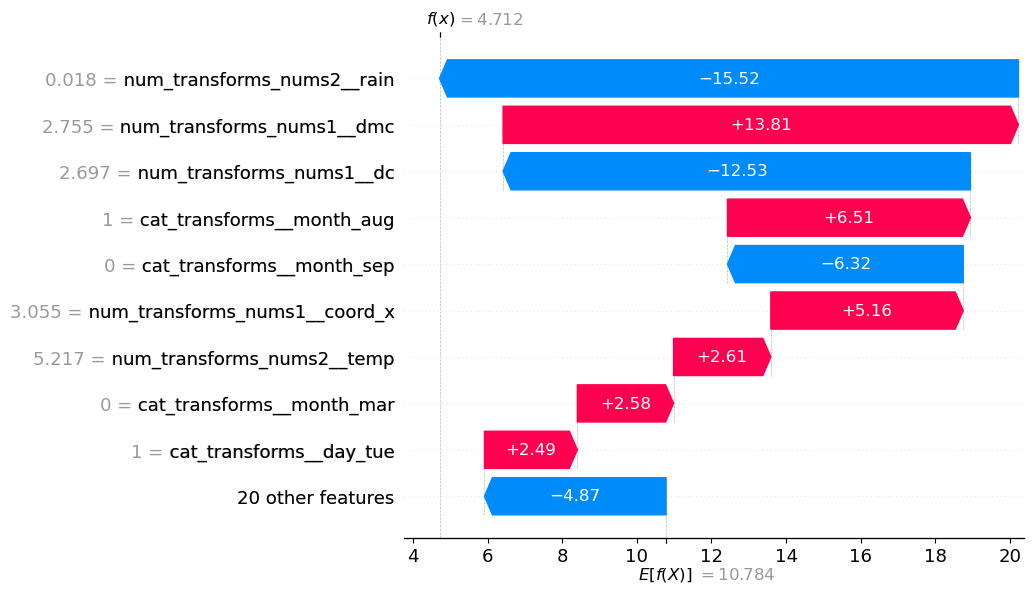

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

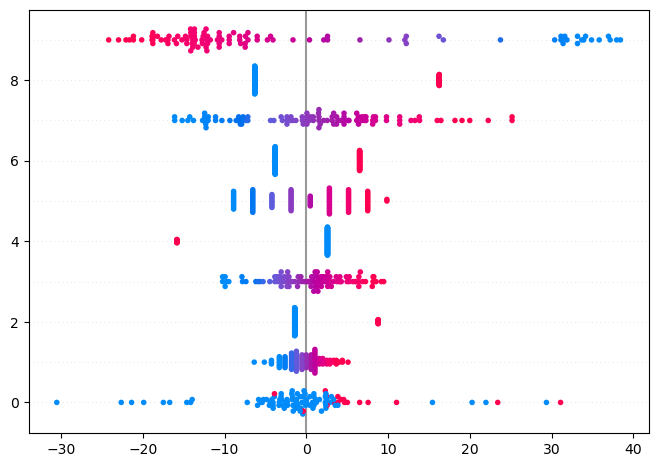

In [32]:
import matplotlib.pyplot as plt

shap_values = explainer(X_test_transformed)
shap.plots.waterfall(shap_values[1])
shap.plots.beeswarm(shap_values)


*(Answer here.)*

Waterfall - Individual Prediction: 

Strongest negative contributors:

num_transforms_nums2__rain: -15.52

num_transforms_nums1__dc: -12.53

Strongest positive contributors:

num_transforms_nums1__dmc: +13.81

cat_transforms__month_aug: +6.51

Beeswarm - Global Feature Importance: The beeswarm plot summarizes SHAP values for all observations, showing which features are most impactful across the data.

Most important features globally:

num_transforms_nums1__dmc (Dry matter content)

num_transforms_nums1__dc (Drought code)

num_transforms_nums2__rain (Rainfall)

cat_transforms__month_aug (August)

num_transforms_nums2__temp (Temperature)

These features have long horizontal spread, meaning they strongly impact predictions either positively or negatively.

Least important features:
Features near the bottom (short or tightly clustered lines) like:

cat_transforms__month_mar

cat_transforms__day_tue

We can remove these low-impact features. These show minimal variation and effect on prediction in the SHAP plots.

To validate this, we would retrain the model without those features and compare the RMSE and MAE with the full-feature model.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.